In [1]:
%cd ../../

/home/gergopool/work/uva/atcs/Language-Specific-Subnetworks


In [2]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt
import seaborn as sns
import glob
import numpy as np

from data import ALLOWED_DATASETS, ALLOWED_LANGUAGES
if 'wikiann' in ALLOWED_DATASETS:
    ALLOWED_DATASETS.remove('wikiann')

%matplotlib inline

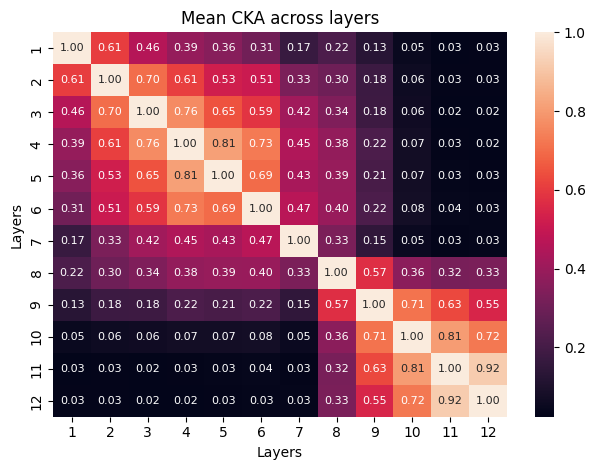

In [3]:
def across_layers(folder='results/cka/validation', save_name="cka_across_layers.pdf"):
    results = []
    filepaths = glob.glob(os.path.join(folder, '*.pkl'))
    for filepath in filepaths:
        sim = torch.load(filepath)
        results.append(sim)
    results = torch.stack(results)
    num_elements = (~torch.isnan(results)).sum(dim=0)
    results = torch.nan_to_num(results).sum(dim=0)
    results /= torch.clip(num_elements, min=1)
        
    layer_ticks = np.arange(12) + 1
    sns.heatmap(results, annot=True, annot_kws={"size": 8},fmt='.2f')
    plt.title("Mean CKA across layers")
    _ = plt.yticks(layer_ticks - 0.5, layer_ticks)
    _ = plt.xticks(layer_ticks - 0.5, layer_ticks)
    plt.xlabel("Layers")
    plt.ylabel("Layers")
    plt.tight_layout()
    plt.savefig(f'results/plots/{save_name}')

across_layers() 

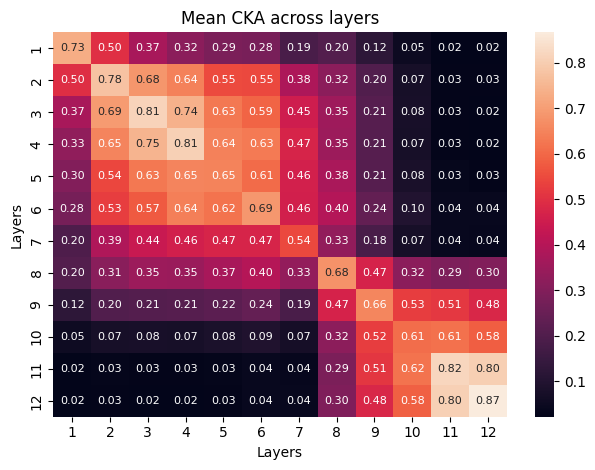

In [4]:
across_layers('results/cka/across_seeds', save_name="cka_across_layers_and_seeds.pdf")

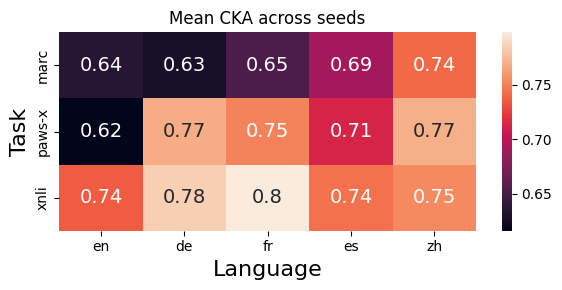

In [5]:
def across_seeds(folder='results/cka/across_seeds'):
    
    n_dataset = len(ALLOWED_DATASETS)
    n_lang = len(ALLOWED_LANGUAGES)
    n_seeds = 5

    results = np.zeros((n_dataset, n_lang))
    sums = np.zeros((n_dataset, n_lang))
    
    filepaths = glob.glob(os.path.join(folder, '*.pkl'))
    for filepath in filepaths:
        sim = torch.load(filepath).diag()
        divider = max((~torch.isnan(sim)).sum(), 1)
        sim = torch.nan_to_num(sim).sum() / divider
        dataset, lang = os.path.split(filepath)[-1].split('_')[:2]
        results[ALLOWED_DATASETS.index(dataset), ALLOWED_LANGUAGES.index(lang)] += sim / n_seeds
        
    plt.figure(figsize=(6,3))
    sns.heatmap(results, annot=True, annot_kws={"fontsize":14})
    plt.title("Mean CKA across seeds")
    _ = plt.yticks([x+0.5 for x in range(n_dataset)], ALLOWED_DATASETS)
    _ = plt.xticks([x+0.5 for x in range(n_lang)], ALLOWED_LANGUAGES)
    plt.xlabel("Language", fontsize=16)
    plt.ylabel("Task", fontsize=16)
    plt.tight_layout()
    plt.savefig('results/plots/cka_across_seeds.pdf')
    
across_seeds()

Offdiag stats: 0.0007450219515400628 +- 0.00019510367079019947


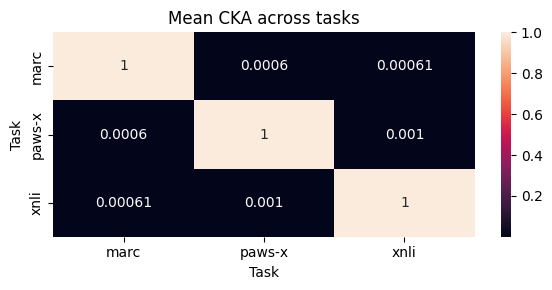

In [6]:
def across_tasks(offdiag_folder='results/cka/across_tasks', diag_folder='results/cka/validation/'):
    
    n_tasks = len(ALLOWED_DATASETS)
    n_lang = len(ALLOWED_LANGUAGES)
    
    def loop_over(filepaths):
        results = np.zeros((n_tasks, n_tasks))
        for filepath in filepaths:
            sim = torch.load(filepath).diag()
            divider = max((~torch.isnan(sim)).sum(), 1)
            sim = torch.nan_to_num(sim).sum() / divider
            run_info = os.path.split(filepath)[-1].split('_')
            task1, task2 = run_info[0], run_info[3]
            results[ALLOWED_DATASETS.index(task1), ALLOWED_DATASETS.index(task2)] += sim / n_lang
        return results
    
    
    
    # Off diagonal
    off_diag = loop_over(glob.glob(os.path.join(offdiag_folder, '*.pkl')))
    diag = loop_over(glob.glob(os.path.join(diag_folder, '*.pkl')))
    results = off_diag + diag
    
    weights = np.ones_like(off_diag)
    np.fill_diagonal(weights, 0)
    mean = np.average(off_diag, weights=weights)
    std = np.sqrt(np.average((off_diag-mean)**2, weights=weights))
    print(f"Offdiag stats: {mean} +- {std}")
        
    plt.figure(figsize=(6,3))
    sns.heatmap(results, annot=True)
    plt.title("Mean CKA across tasks")
    _ = plt.yticks([x+0.5 for x in range(n_tasks)], ALLOWED_DATASETS)
    _ = plt.xticks([x+0.5 for x in range(n_tasks)], ALLOWED_DATASETS)
    plt.xlabel("Task")
    plt.ylabel("Task")
    plt.tight_layout()
    plt.savefig('results/plots/cka_across_tasks.pdf')
    
across_tasks()

Offdiag stats: 0.42051849514245987 +- 0.03611075798696654


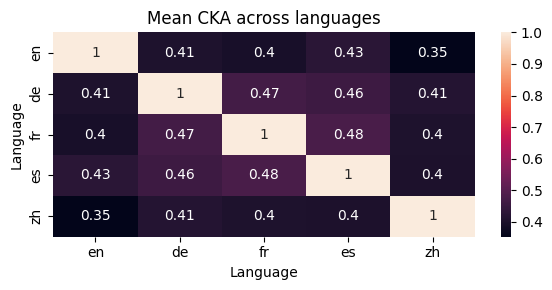

In [7]:
def across_langs(offdiag_folder='results/cka/across_langs', diag_folder='results/cka/validation/'):
    
    n_tasks = len(ALLOWED_DATASETS)
    n_langs = len(ALLOWED_LANGUAGES)
    
    def loop_over(filepaths):
        results = np.zeros((n_langs, n_langs))
        for filepath in filepaths:
            sim = torch.load(filepath).diag()
            divider = max((~torch.isnan(sim)).sum(), 1)
            sim = torch.nan_to_num(sim).sum() / divider
            run_info = os.path.split(filepath)[-1].split('_')
            lang1, lang2 = run_info[1], run_info[4]
            results[ALLOWED_LANGUAGES.index(lang1), ALLOWED_LANGUAGES.index(lang2)] += sim / n_tasks
        return results
    
    
    
    # Off diagonal
    off_diag = loop_over(glob.glob(os.path.join(offdiag_folder, '*.pkl')))
    diag = loop_over(glob.glob(os.path.join(diag_folder, '*.pkl')))
    results = off_diag + diag
    
    
    weights = np.ones_like(off_diag)
    np.fill_diagonal(weights, 0)
    mean = np.average(off_diag, weights=weights)
    std = np.sqrt(np.average((off_diag-mean)**2, weights=weights))
    print(f"Offdiag stats: {mean} +- {std}")
    
        
    plt.figure(figsize=(6,3))
    sns.heatmap(results, annot=True)
    plt.title("Mean CKA across languages")
    _ = plt.yticks([x+0.5 for x in range(n_langs)], ALLOWED_LANGUAGES)
    _ = plt.xticks([x+0.5 for x in range(n_langs)], ALLOWED_LANGUAGES)
    plt.xlabel("Language")
    plt.ylabel("Language")
    plt.tight_layout()
    plt.savefig('results/plots/cka_across_languages.pdf')
    
across_langs()